In [1]:
from matplotlib import pyplot, patches
import csv
import os
from PIL import Image
from torchvision.models import ResNet101_Weights
import torch
import json
import math
import random
from mlt.preexperiments.data_readers import PreprocessScratch

ModuleNotFoundError: No module named 'mlt'

In [2]:
def recalculate_pixels(target_pixels, image_size, preprocess):
    new_x, new_y = target_pixels
    image_x, image_y = image_size
    
    if len(preprocess.resize_size) == 1:
        resize_x = preprocess.resize_size[0]
        resize_y = preprocess.resize_size[0]
    else:
        resize_x, resize_y = preprocess.resize_size
    
    cropped_image_x = min(image_x, resize_x)
    cropped_image_y = min(image_y, resize_y)
    
    if preprocess.crop_size != None:
        new_x = float(new_x + ((cropped_image_x - preprocess.crop_size[0]) / 2))
        new_y = float(new_y + ((cropped_image_y - preprocess.crop_size[0]) / 2))

    new_x = float(new_x * (image_x / cropped_image_x))
    new_y = float(new_y * (image_y / cropped_image_y))
    
    return new_x, new_y

In [3]:
def show_picture(file, dataset_root_dir, number, preprocess, choose_random=True):
    with open(file, 'r', encoding='utf-8') as f:
        content = list(csv.reader(f, delimiter=','))[1:]

        if choose_random:
            images = random.sample(content, number)
        else:
            images = content[:number]
        
        number_cols = 3
        number_rows = math.ceil(number / number_cols)
        fig, ax = pyplot.subplots(nrows=number_rows, ncols=number_cols)
        fig.set_figwidth(5 * number_cols)
        fig.set_figheight(3 * number_rows)
        fig.tight_layout()
        
        for index, (image_id, x, y, target_x, target_y) in enumerate(images):            
            x, y, target_x, target_y = float(x), float(y), float(target_x), float(target_y)
            
            image = Image.open(os.path.join(dataset_root_dir, 'images/', image_id) + '.png')
            print(x,y)

            x, y = recalculate_pixels((x, y), image.size, preprocess)
            target_x, target_y = recalculate_pixels((target_x, target_y), image.size, preprocess)

            plot_x = int(index/number_cols)
            plot_y = index % number_cols

            if number_rows == 1:
                grid_coords = plot_y
            else:
                grid_coords = plot_x, plot_y

            ax[grid_coords].imshow(image)
            ax[grid_coords].set_title(image_id)
            ax[grid_coords].add_patch(patches.Circle((x, y), 5, linewidth=2, edgecolor='r', facecolor='none'))
            ax[grid_coords].add_patch(patches.Circle((target_x, target_y), 5, linewidth=2, edgecolor='g', facecolor='none'))

            ax[grid_coords].text(10, 20, f'distance: {round(math.dist((x, y), (target_x, target_y)), 2)}')

        pyplot.show()


In [4]:
def show_distribution(file, dataset_root_dir, preprocess):
    with open(file, 'r', encoding='utf-8') as f:
        content = csv.reader(f, delimiter=',')

        first_image_path = os.listdir(os.path.join(dataset_root_dir, 'images/'))[0]
        first_image = Image.open(os.path.join(dataset_root_dir, 'images/', first_image_path))
        image_size = first_image.size
        general_fig, general_ax = pyplot.subplots()
        general_ax.imshow(first_image)

        next(content)
        for image_id, x, y, target_x, target_y in content:            
            x, y, target_x, target_y = float(x), float(y), float(target_x), float(target_y)

            x, y = recalculate_pixels((x, y), image_size, preprocess)
            target_x, target_y = recalculate_pixels((target_x, target_y), image_size, preprocess)

            general_ax.add_patch(patches.Circle((x, y), 1, linewidth=2, edgecolor='r', facecolor='none'))
            general_ax.add_patch(patches.Circle((target_x, target_y), 1, linewidth=2, edgecolor='g', facecolor='none'))

        pyplot.show()


In [5]:
preprocess_pretrained = ResNet101_Weights.DEFAULT.transforms()
preprocess_scratch = PreprocessScratch(250)

In [6]:
# project_root_dir = '/home/guskunkdo@GU.GU.SE/MLT_Master-Thesis/'
project_root_dir = '/home/dominik/Nextcloud/020_Masterstudium/Language Technology/LT2402_Master Thesis/experiments/pre-experiments/'
# project_root_dir = '/home/dominik/Development/MLT_Master-Thesis/out/'
model_dir = os.path.join(project_root_dir, 'coordinate_predictor/dale/2023-11-11_05-35-18_dale_attribute_coordinate_predictor_dale-5_300_2048_1500_15_0.0001/')
# dataset_image_dir = '/scratch/guskunkdo/clevr-images-unambigous-colour/'
dataset_image_dir = '/home/dominik/Development/clevr-images-unambigous-dale/'
preprocess = preprocess_pretrained

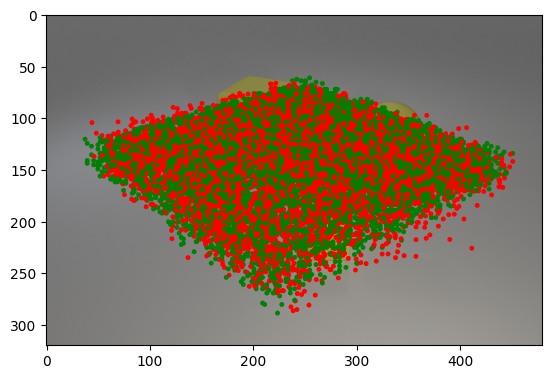

In [34]:
show_distribution(os.path.join(model_dir, 'train_outputs.csv'), dataset_image_dir, preprocess)

73.3328857421875 93.59130096435547
95.8514633178711 107.50955200195312
71.83349609375 101.3431625366211


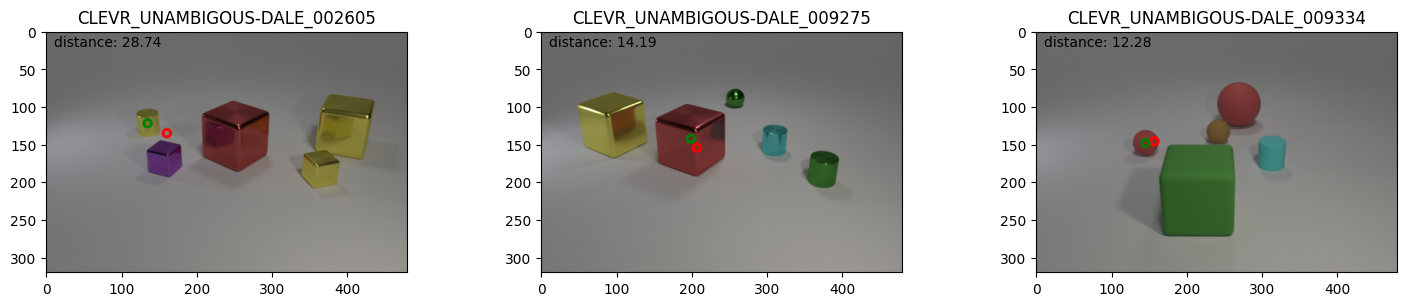

In [60]:
show_picture(os.path.join(model_dir, 'train_outputs.csv'), dataset_image_dir, 3, preprocess)

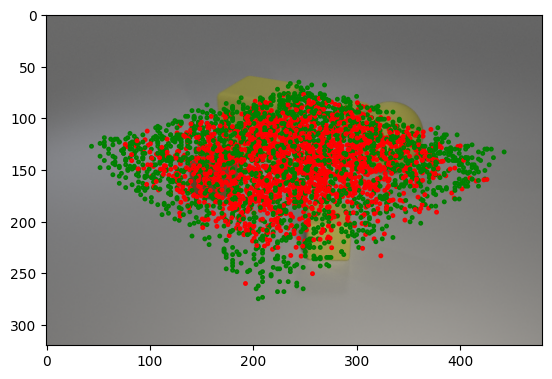

In [36]:
show_distribution(os.path.join(model_dir, 'test_outputs.csv'), dataset_image_dir, preprocess)

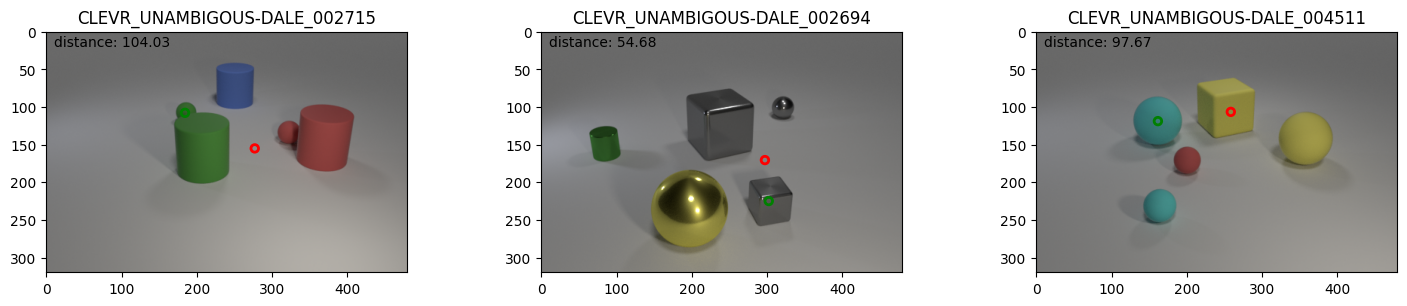

In [37]:
show_picture(os.path.join(model_dir, 'test_outputs.csv'), dataset_image_dir, 3, preprocess)

# Attention

In [7]:
def recalculate_edge(edge, image_size, preprocess):
    x, y = edge

    resize_x = preprocess.resize_size[0] * image_size[0] / min(image_size[1], image_size[0])
    resize_y = preprocess.resize_size[0] * image_size[1] / min(image_size[1], image_size[0])

    new_x = (x + ((resize_x - preprocess.crop_size[0]) / 2)) * image_size[0] / resize_x
    new_y = (y + ((resize_y - preprocess.crop_size[0]) / 2)) * image_size[1] / resize_y

    return new_x, new_y

In [8]:
def show_attention_picture(file, dataset_root_dir, number, preprocess, max_probability_mass, choose_random=True):
    with open(file, 'r', encoding='utf-8') as f:
        content = list(csv.reader(f, delimiter=','))[1:]
        
    number_cols = 3
    number_rows = math.ceil(number / number_cols)
    fig, ax = pyplot.subplots(nrows=number_rows, ncols=number_cols)
    fig.set_figwidth(5 * number_cols)
    fig.set_figheight(3 * number_rows)
    fig.tight_layout()
    
    chosen_images = set()
    image_index = 0
    while image_index < number and len(content) > 0:
        image_id, predicted, target = content.pop(random.randrange(len(content)))
        if image_id in chosen_images:
            continue

        predicted = [float(region) for region in predicted.removeprefix('[').removesuffix(']').split(';')]         
        target = [float(region) for region in target.removeprefix('[').removesuffix(']').split(';')] 
        probability_mass = sum(p * t for p, t in zip(predicted, target))

        if probability_mass > max_probability_mass:
            continue

        image = Image.open(os.path.join(dataset_root_dir, 'images/', image_id) + '.png')
        with open(os.path.join(dataset_root_dir, 'scenes/', image_id) + '.json', 'r', encoding='utf-8') as f:
            scene = json.load(f)
        target_object = scene['objects'][0] 
        target_object_string = f"{target_object['size']} {target_object['color']} {target_object['shape']}"

        number_regions = math.sqrt(len(predicted))
        region_size = preprocess.crop_size[0] / number_regions
        area_size = number_regions * region_size

        area_start_x, area_start_y = recalculate_edge((0,0), image.size, preprocess)
        area_end_x, area_end_y = recalculate_edge((area_size,area_size), image.size, preprocess)

        plot_x = int(image_index/number_cols)
        plot_y = image_index % number_cols

        if number_rows == 1:
            grid_coords = plot_y
        else:
            grid_coords = plot_x, plot_y

        ax[grid_coords].imshow(image)
        ax[grid_coords].set_title(image_id)
        ax[grid_coords].add_patch(patches.Rectangle(
            (area_start_x, area_start_y),
            area_end_x - area_start_x,
            area_end_y - area_start_y,
            facecolor='none',
            linewidth=1,
            edgecolor='black'
        ))

        # prerequisite: target is a rectangle
        start_region = target.index(1)
        end_region = len(target) - 1 - target[::-1].index(1)

        region_start_x = (start_region % number_regions) * region_size
        region_start_y = int(start_region / number_regions) * region_size
        region_end_x = (end_region % number_regions) * region_size + region_size
        region_end_y = int(end_region / number_regions) * region_size + region_size
        region_end_x, region_end_y = recalculate_edge((region_end_x, region_end_y), image.size, preprocess)
        region_start_x, region_start_y = recalculate_edge((region_start_x, region_start_y), image.size, preprocess)

        ax[grid_coords].add_patch(patches.Rectangle(
            (region_start_x, region_start_y),
            region_end_x - region_start_x,
            region_end_y - region_start_y,
            edgecolor='green',
            linewidth=2,
            facecolor='none'
        ))

        for region_index, region in enumerate(predicted):
            # print(f"{region_index=}", f"{region=}")
            region_start_x = (region_index % number_regions) * region_size
            region_start_y = int(region_index / number_regions) * region_size
            region_end_x ,region_end_y =  recalculate_edge(
                (region_start_x + region_size, 
                    region_start_y + region_size),
                image.size,
                preprocess
            )
            region_start_x, region_start_y = recalculate_edge((region_start_x, region_start_y), image.size, preprocess)

            # print(f"{region_start_x=}", f"{region_start_y=}")
            # print(f"{region_end_x=}", f"{region_end_y=}")

            ax[grid_coords].add_patch(patches.Rectangle(
                (region_start_x, region_start_y),
                region_end_x - region_start_x,
                region_end_y - region_start_y,
                facecolor='r',
                alpha=min(1, region * 1.6)
            ))
    

        ax[grid_coords].text(image.width / 2, 30, f"Probability mass: {probability_mass:.2%}", horizontalalignment='center')
        ax[grid_coords].text(image.width / 2, 305, f"Target: {target_object_string}", horizontalalignment='center')

        chosen_images.add(image_id)
        image_index += 1


    pyplot.show()


In [59]:
# project_root_dir = '/home/guskunkdo@GU.GU.SE/MLT_Master-Thesis/'
project_root_dir = '/home/dominik/Nextcloud/020_Masterstudium/Language Technology/LT2402_Master Thesis/experiments/language-games/bb_attention_predictor'
# project_root_dir = '/home/dominik/Development/MLT_Master-Thesis/out/language-games/bb_attention_predictor/'
model_dir = os.path.join(project_root_dir, '2023-12-08_09-38-01_bounding_box_attention_predictor_dale-2_2_100_500_500_100_500_500_10/')
# dataset_image_dir = '/scratch/guskunkdo/clevr-images-unambigous-colour/'
dataset_image_dir = '/home/dominik/Development/clevr-images-unambigous-dale-two/'
preprocess = preprocess_pretrained

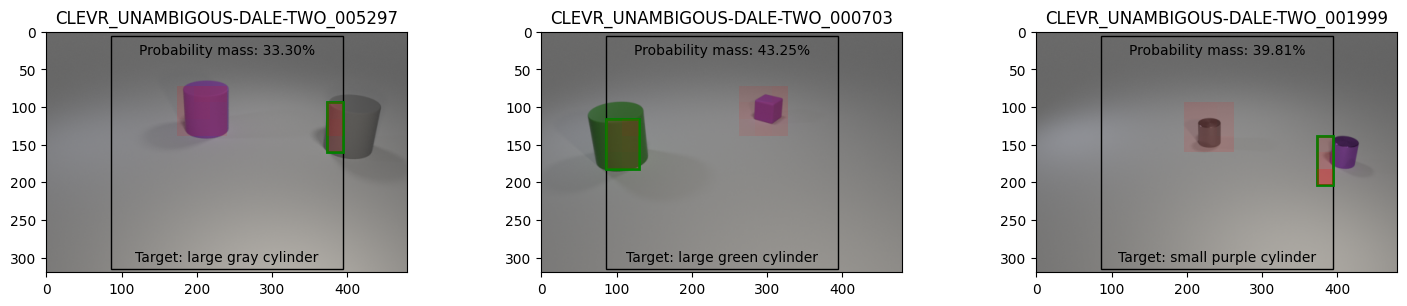

In [76]:
show_attention_picture(file=os.path.join(model_dir, 'test_outputs.csv'),
                       dataset_root_dir=dataset_image_dir,
                       number=3,
                       max_probability_mass=0.5,
                       preprocess=preprocess)

In [41]:
from matplotlib import ticker


def show_boxplot(files, labels):
    data = []
    for file in files:
        with open(file, 'r', encoding='utf-8') as f:
            content = list(csv.reader(f, delimiter=','))[1:]

        probability_masses = []
        for image_id, predicted, target in content:
            predicted = [float(region) for region in predicted.removeprefix('[').removesuffix(']').split(';')]         
            target = [float(region) for region in target.removeprefix('[').removesuffix(']').split(';')] 
            probability_masses.append(sum(p * t for p, t in zip(predicted, target)))
        data.append(probability_masses)
    
    pyplot.boxplot(
        data,
        labels=labels,
        patch_artist=True,
        showmeans=True,
        meanline=True,
    )
    pyplot.grid(True)
    pyplot.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.1))

    

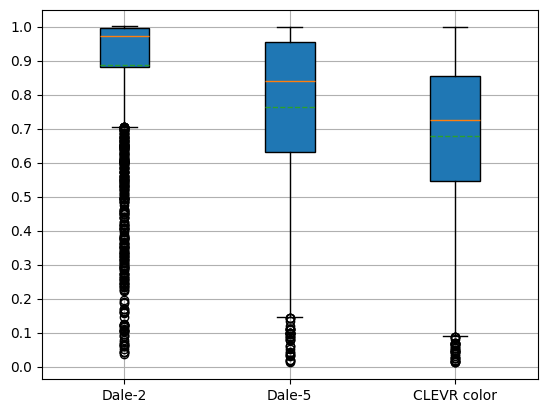

In [45]:
data = {
    'Dale-2': os.path.join(project_root_dir, '2024-03-16_16-31-15_bounding_box_attention_predictor_dale-2_4_500_500_500_100_500_500_2', 'test_outputs.csv'),
    'Dale-5': os.path.join(project_root_dir, '2023-12-08_14-18-15_bounding_box_attention_predictor_dale-5_1_100_500_500_100_500_500_50', 'test_outputs.csv'), 
    'CLEVR color': os.path.join(project_root_dir, '2023-12-08_17-12-50_bounding_box_attention_predictor_colour_3_100_500_500_100_500_500_16', 'test_outputs.csv')
}


show_boxplot(data.values(), data.keys())

In [46]:
image = Image.open(os.path.join(dataset_image_dir, 'images/', 'CLEVR_UNAMBIGOUS-DALE-TWO_007252') + '.png').convert('RGB')
image

FileNotFoundError: [Errno 2] No such file or directory: '/home/dominik/Development/clevr-images-unambigous-dale/images/CLEVR_UNAMBIGOUS-DALE-TWO_007252.png'

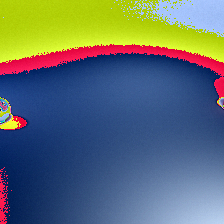

In [ ]:
from torchvision.transforms import ToPILImage
preprocessed = preprocess(image)
to_pil = ToPILImage()
to_pil(preprocessed)